In [54]:
import os

import pickle

import tsplib95

import csv
import time

import pandas as pd

import numpy as np

import networkx as nx

from simulated_annealing import SimulateAnnealing

from networkx.algorithms.approximation.traveling_salesman import *

from mst import MST

import json

import matplotlib.pyplot as plt
from itertools import pairwise

In [55]:
def get_tsp_graph(name) -> nx.Graph:
    # load from pkl file if exists
    graph_file_path = os.path.join("tsp_dataset", f"{name}.graph.pkl")
    if os.path.exists(graph_file_path):
        # print(f"Loading {name} from pkl {graph_file_path}")
        with open(graph_file_path, "rb") as file:
            G = pickle.load(file)
        return G.to_undirected()

    tsp_file_path = os.path.join("tsp_dataset", f"{name}.tsp")
    # print(f"Loading {name} from tsplib {tsp_file_path}")
    problem = tsplib95.load(tsp_file_path)
    G = problem.get_graph()

    # remove redundant edges
    if problem.edge_weight_type == "EXPLICIT" and problem.edge_weight_format == "FULL_MATRIX":
        for u in G.nodes:
            for v in G.nodes:
                if u > v:
                    G.remove_edge(u, v)

    # remove self loops
    loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(loop_edges)

    # save as pkl file
    with open(graph_file_path, "wb") as file:
        print(f"Saving {name} to pkl {graph_file_path}")
        pickle.dump(G, file)

    return G

In [56]:
tsp_dataset_file_path = os.path.join("tsp_dataset", "tsp_dataset.csv")
print(f"Loading tsp dataset from {tsp_dataset_file_path}")
tsp_dataset = pd.read_csv(tsp_dataset_file_path)

Loading tsp dataset from tsp_dataset\tsp_dataset.csv


In [57]:
def get_opt_tour_length(name):
    return tsp_dataset[tsp_dataset["name"] == name]["opt_tour_length"].values[0]

In [58]:
def get_tour_length(G: nx.graph, tour: list):
    tour_length = 0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i + 1]
        w = G[u][v]["weight"]
        tour_length += w
    return tour_length

In [59]:
def get_apx_ratio(G: nx.graph, tour: list):
    return get_tour_length(G, tour) / get_opt_tour_length(G.name)

In [60]:
tsp_dataset

,name,dimension,opt_tour_length,type,comment,edge_weight_type,edge_weight_format
0,burma14,14,3323,TSP,14-Staedte in Burma (Zaw Win),GEO,FUNCTION
1,ulysses16,16,6859,TSP,Odyssey of Ulysses (Groetschel/Padberg),GEO,NaN
2,gr17,17,2085,TSP,17-city problem (Groetschel),EXPLICIT,LOWER_DIAG_ROW
3,gr21,21,2707,TSP,21-city problem (Groetschel),EXPLICIT,LOWER_DIAG_ROW
4,ulysses22,22,7013,TSP,Odyssey of Ulysses (Groetschel/Padberg),GEO,NaN
...,...,...,...,...,...,...,...
91,u2319,2319,234256,TSP,Drilling problem (Reinelt),EUC_2D,NaN
92,pr2392,2392,378032,TSP,2392-city problem (Padberg/Rinaldi),EUC_2D,NaN
93,pcb3038,3038,137694,TSP,Drilling problem (Junger/Reinelt),EUC_2D,NaN
94,fnl4461,4461,182566,TSP,Die 5 neuen Laender Deutschlands (Ex-DDR) (Bac...,EUC_2D,NaN


In [61]:
def get_total_edge_weight(G: nx.graph):
    total_edge_weight = 0
    for u, v in G.edges:
        total_edge_weight += G[u][v]["weight"]
    return total_edge_weight

c_tour_length: 3559 , c_apx_ratio: 1.0710201625037616
r_tour_length: 3453 , r_apx_ratio: 1.039121275955462


mst_cost: 2345
rst_cost: 2459
mst_pm_cost: 1319
rst_pm_cost: 1189
mst_tg_cost: 3559
rst_tg_cost: 3453


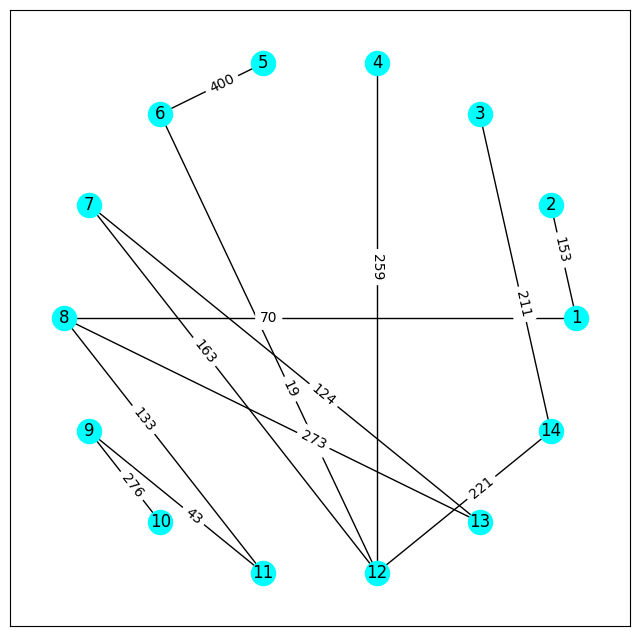

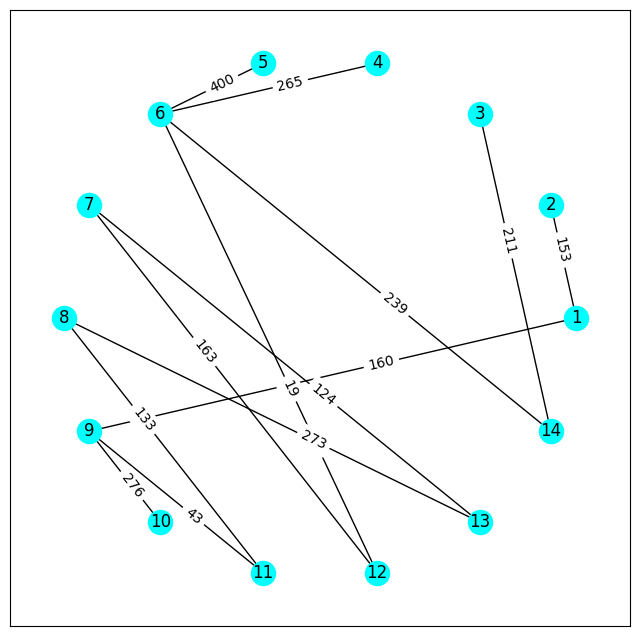

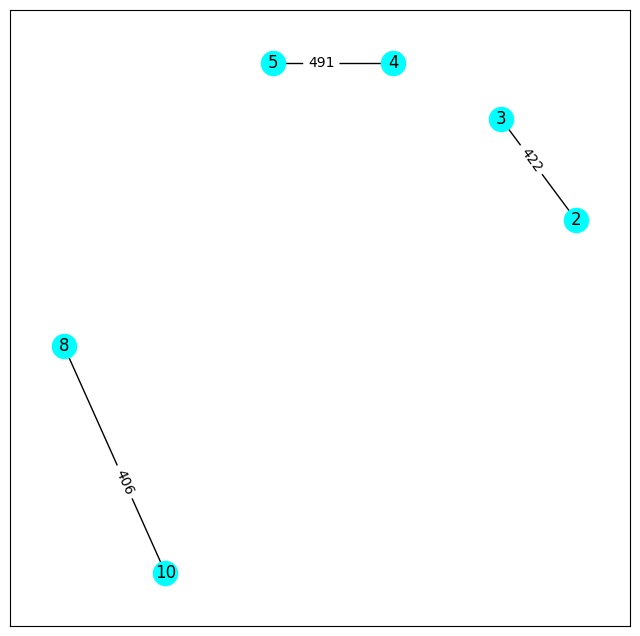

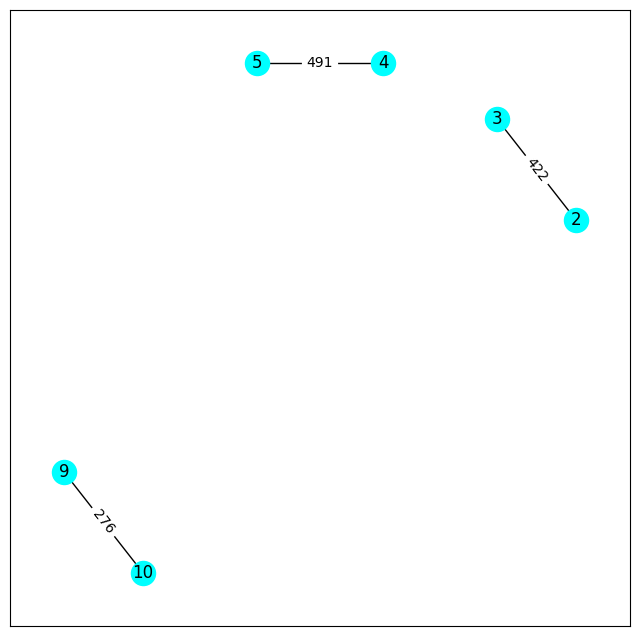

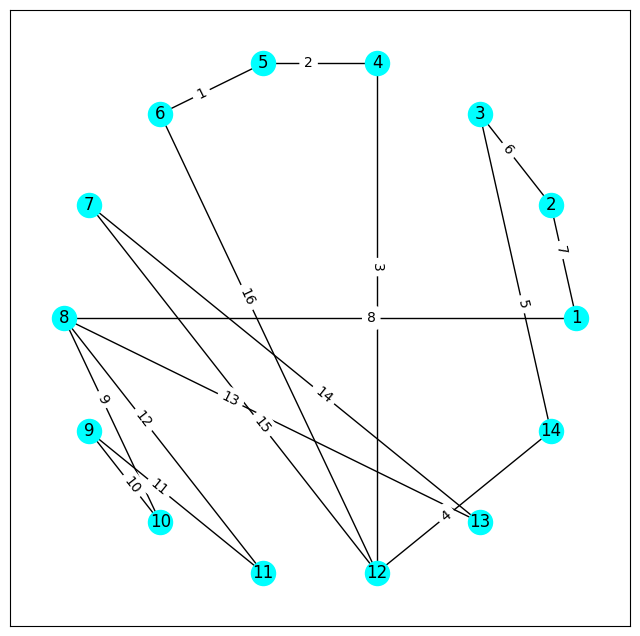

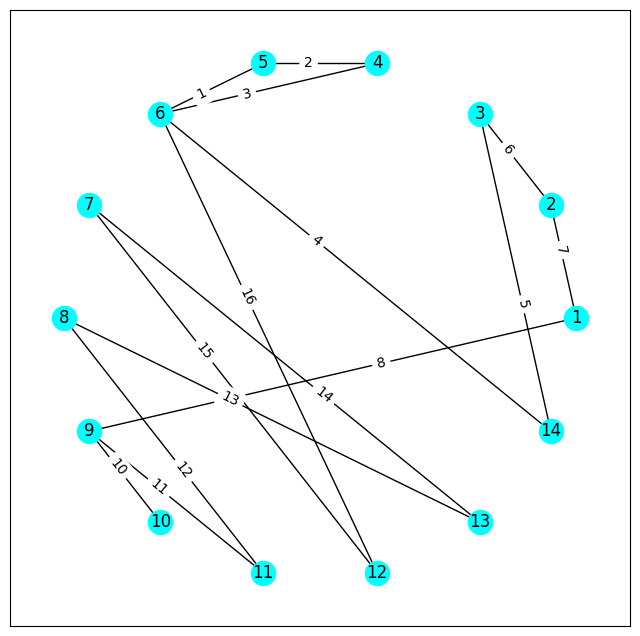

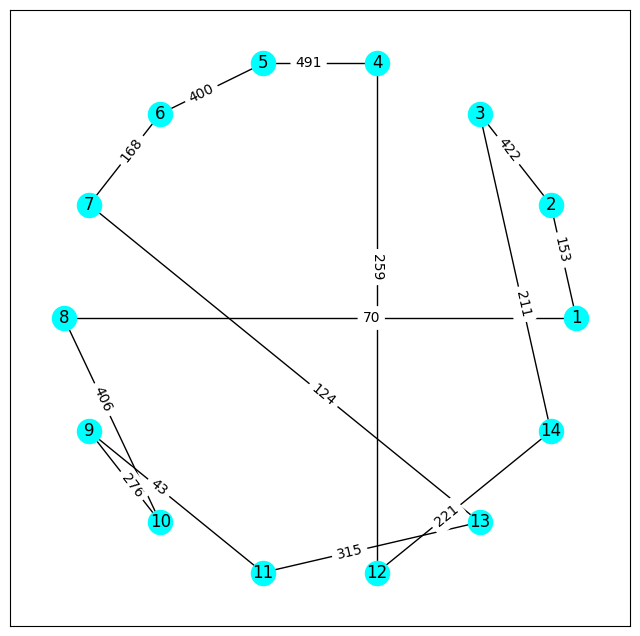

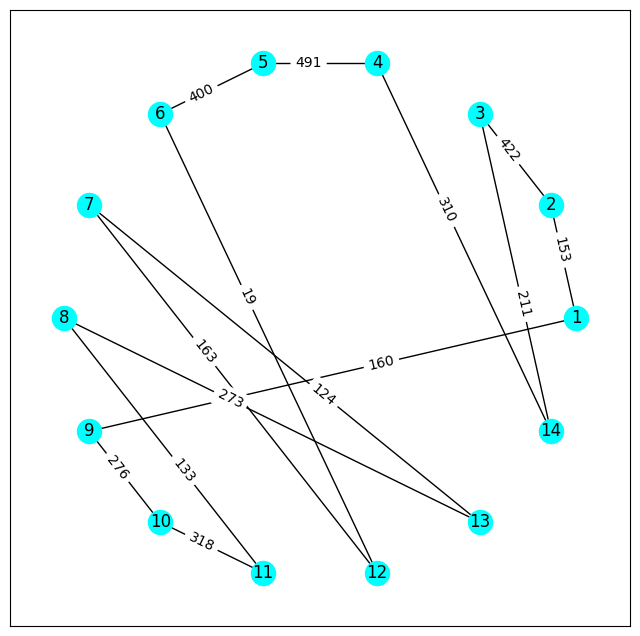

In [62]:
name = "burma14"
best_k = 11

G = get_tsp_graph(name)
dimension = G.number_of_nodes()
opt_tour_length = get_opt_tour_length(name)

mst = MST.get_mst_k(graph=G, k=1, seed=49)
mst_cost = get_total_edge_weight(mst)

c_tour = christofides(G, tree=mst)
c_tour_length = get_tour_length(G, c_tour)
c_apx_ratio = c_tour_length / opt_tour_length

rst = MST.get_mst_k(graph=G, k=best_k, seed=49)
rst_cost = get_total_edge_weight(rst)

r_tour = christofides(G, tree=rst)
r_tour_length = get_tour_length(G, r_tour)
r_apx_ratio = r_tour_length / opt_tour_length

print("c_tour_length:", c_tour_length, ", c_apx_ratio:", c_apx_ratio)
print("r_tour_length:", r_tour_length, ", r_apx_ratio:", r_apx_ratio)

nodes = list(G.nodes)
nodes = sorted(nodes)
pos = nx.circular_layout(G)

plt.figure(figsize=(8, 8))

nx.draw_networkx(mst, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(mst, "weight")
nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, label_pos=0.4, font_size=10)

# plt.title("MST")
plt.savefig("figs/mst.png")
# plt.show()

print("mst_cost:", mst_cost)

plt.figure(figsize=(8, 8))

nx.draw_networkx(rst, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(rst, "weight")
nx.draw_networkx_edge_labels(rst, pos, edge_labels=edge_labels, label_pos=0.4, font_size=10)

# plt.title("RST")
plt.savefig("figs/rst.png")
# plt.show()

print("rst_cost:", rst_cost)

mst_odd = G.copy()
mst_odd.remove_nodes_from([v for v, degree in mst.degree if not (degree % 2)])
mst_pm = nx.Graph()
mst_pm.add_edges_from(nx.min_weight_matching(mst_odd, maxcardinality=True, weight="weight"))
for u, v in mst_pm.edges:
    mst_pm[u][v]["weight"] = G[u][v]["weight"]
mst_pm_cost = get_total_edge_weight(mst_pm)

rst_odd = G.copy()
rst_odd.remove_nodes_from([v for v, degree in rst.degree if not (degree % 2)])
rst_pm = nx.Graph()
rst_pm.add_edges_from(nx.min_weight_matching(rst_odd, maxcardinality=True, weight="weight"))
for u, v in rst_pm.edges:
    rst_pm[u][v]["weight"] = G[u][v]["weight"]
rst_pm_cost = get_total_edge_weight(rst_pm)

plt.figure(figsize=(8, 8))

nx.draw_networkx(mst_pm, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(mst_pm, "weight")
nx.draw_networkx_edge_labels(
    mst_pm, pos, edge_labels=edge_labels, label_pos=0.4, font_size=10
)

plt.savefig("figs/mst_pm.png")
# plt.show()
print("mst_pm_cost:", mst_pm_cost)

plt.figure(figsize=(8, 8))

nx.draw_networkx(rst_pm, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(rst_pm, "weight")
nx.draw_networkx_edge_labels(rst_pm, pos, edge_labels=edge_labels)

plt.savefig("figs/rst_pm.png")
# plt.show()
print("rst_pm_cost:", rst_pm_cost)

mst_mg = nx.MultiGraph()
mst_mg.add_edges_from(mst.edges)
mst_mg.add_edges_from(mst_pm.edges)

rst_mg = nx.MultiGraph()
rst_mg.add_edges_from(rst.edges)
rst_mg.add_edges_from(rst_pm.edges)

# plt.figure(figsize=(8, 8))
#
# nx.draw_networkx(mst_mg, pos, with_labels=True, node_color="cyan", font_color="black")
# edge_labels = nx.get_edge_attributes(mst_mg, "weight")
# nx.draw_networkx_edge_labels(
#     mst_mg, pos, edge_labels=edge_labels, label_pos=0.4, font_size=10
# )
#
# plt.savefig("figs/mst_mg.png")
# # plt.show()
# print("mst_mg_cost:", mst_mg_cost)
#
# plt.figure(figsize=(8, 8))
#
# nx.draw_networkx(rst_mg, pos, with_labels=True, node_color="cyan", font_color="black")
# edge_labels = nx.get_edge_attributes(rst_mg, "weight")
# nx.draw_networkx_edge_labels(
#     rst_mg, pos, edge_labels=edge_labels, label_pos=0.4, font_size=10
# )
#
# plt.savefig("figs/rst_mg.png")
# # plt.show()
# print("rst_mg_cost:", rst_mg_cost)


mst_ec_edges = list(nx.eulerian_circuit(mst_mg))
mst_ec = nx.Graph()
mst_ec.add_edges_from(mst_ec_edges)
for i, edges in enumerate(mst_ec_edges):
    u, v = edges
    mst_ec[u][v]["weight"] = i + 1

rst_ec_edges = list(nx.eulerian_circuit(rst_mg))
rst_ec = nx.Graph()
rst_ec.add_edges_from(rst_ec_edges)
for i, edges in enumerate(rst_ec_edges):
    u, v = edges
    rst_ec[u][v]["weight"] = i + 1

plt.figure(figsize=(8, 8))

nx.draw_networkx(mst_ec, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(mst_ec, "weight")
nx.draw_networkx_edge_labels(
    mst_ec, pos, edge_labels=edge_labels, label_pos=0.6, font_size=10
)

plt.savefig("figs/mst_ec.png")
# plt.show()

plt.figure(figsize=(8, 8))

nx.draw_networkx(rst_ec, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(rst_ec, "weight")
nx.draw_networkx_edge_labels(
    rst_ec, pos, edge_labels=edge_labels, label_pos=0.6, font_size=10
)

plt.savefig("figs/rst_ec.png")
# plt.show()

mst_tg = nx.Graph()
for u, v in pairwise(c_tour):
    mst_tg.add_edge(u, v, weight=G[u][v]["weight"])
mst_tg_cost = get_total_edge_weight(mst_tg)

rst_tg = nx.Graph()
for u, v in pairwise(r_tour):
    rst_tg.add_edge(u, v, weight=G[u][v]["weight"])
rst_tg_cost = get_total_edge_weight(rst_tg)


plt.figure(figsize=(8, 8))

nx.draw_networkx(mst_tg, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(mst_tg, "weight")
nx.draw_networkx_edge_labels(
    mst_tg, pos, edge_labels=edge_labels, label_pos=0.6, font_size=10
)

plt.savefig("figs/mst_tg.png")
# plt.show()
print("mst_tg_cost:", mst_tg_cost)

plt.figure(figsize=(8, 8))

nx.draw_networkx(rst_tg, pos, with_labels=True, node_color="cyan", font_color="black")
edge_labels = nx.get_edge_attributes(rst_tg, "weight")
nx.draw_networkx_edge_labels(
    rst_tg, pos, edge_labels=edge_labels, label_pos=0.6, font_size=10
)

plt.savefig("figs/mst_tg.png")
# plt.show()
print("rst_tg_cost:", rst_tg_cost)

In [63]:
mst_edges = list(mst.edges(data=True))
mst_edges.sort(key=lambda x: x[2]["weight"])

rst_edges = list(rst.edges(data=True))
rst_edges.sort(key=lambda x: x[2]["weight"])

mst_edges_set = set(mst.edges)
rst_edges_set = set(rst.edges)
common_edges = mst_edges_set.intersection(rst_edges_set)
mst_only_edges = mst_edges_set - common_edges
rst_only_edges = rst_edges_set - common_edges

common_edges = list(((u, v, G[u][v]["weight"]) for u, v in common_edges))
common_edges = sorted(common_edges, key=lambda x: x[2])
mst_only_edges = list(((u, v, G[u][v]["weight"]) for u, v in mst_only_edges))
mst_only_edges = sorted(mst_only_edges, key=lambda x: x[2])
rst_only_edges = list(((u, v, G[u][v]["weight"]) for u, v in rst_only_edges))
rst_only_edges = sorted(rst_only_edges, key=lambda x: x[2])

In [64]:
print("mst_edges:", mst_edges)
print("rst_edges:", rst_edges)
print("common_edges:", common_edges)
print("mst_only_edges:", mst_only_edges)
print("rst_only_edges:", rst_only_edges)

mst_edges: [(6, 12, {'weight': 19}), (9, 11, {'weight': 43}), (1, 8, {'weight': 70}), (7, 13, {'weight': 124}), (11, 8, {'weight': 133}), (1, 2, {'weight': 153}), (12, 7, {'weight': 163}), (3, 14, {'weight': 211}), (12, 14, {'weight': 221}), (12, 4, {'weight': 259}), (8, 13, {'weight': 273}), (9, 10, {'weight': 276}), (6, 5, {'weight': 400})]
rst_edges: [(6, 12, {'weight': 19}), (9, 11, {'weight': 43}), (7, 13, {'weight': 124}), (11, 8, {'weight': 133}), (1, 2, {'weight': 153}), (9, 1, {'weight': 160}), (12, 7, {'weight': 163}), (14, 3, {'weight': 211}), (6, 14, {'weight': 239}), (6, 4, {'weight': 265}), (8, 13, {'weight': 273}), (9, 10, {'weight': 276}), (6, 5, {'weight': 400})]
common_edges: [(6, 12, 19), (9, 11, 43), (7, 13, 124), (11, 8, 133), (1, 2, 153), (12, 7, 163), (8, 13, 273), (9, 10, 276), (6, 5, 400)]
mst_only_edges: [(1, 8, 70), (3, 14, 211), (12, 14, 221), (12, 4, 259)]
rst_only_edges: [(9, 1, 160), (14, 3, 211), (6, 14, 239), (6, 4, 265)]
